In [28]:
# utils.py
import torch
import torchvision
# from dataset import CarvanaDataset
from torch.utils.data import DataLoader

# train.py
import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
# from model import UNET
# from utils import (
#     load_checkpoint,
#     save_checkpoint,
#     get_loaders,
#     check_accuracy,
#     save_predictions_as_imgs,
# )

# model.py
import torch
import torch.nn as nn
import torchvision.transforms.functional as TF

# inference.py
import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2
from PIL import Image
#from model import UNET
import numpy as np
import argparse
from skimage.morphology import binary_dilation
import os
import tifffile as tif
import matplotlib.pyplot as plt
import pandas as pd

from torch.utils.data import DataLoader, Dataset

import base64
from pycocotools import _mask as coco_mask
import typing as t
import zlib

# dataset.py
import os
from PIL import Image
from torch.utils.data import Dataset
import numpy as np


# Previous Notebook - Untitled.ipynb

import os, glob
import sys
import json
from PIL import Image
from collections import Counter

import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import plotly.offline as pyo
import tifffile as tif
import matplotlib.pyplot as plt
from tqdm import tqdm

import cv2
import albumentations as A


from sklearn.model_selection import KFold

import copy
import io
from contextlib import redirect_stdout


import pycocotools.mask as mask_util
import torch
from torchvision import datasets
import utils
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

#sys.path.append("/kaggle/input/detection-wheel")


In [2]:
import torch
torch.cuda.is_available()

True

In [3]:
torch.__version__

'2.0.1'

In [4]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [5]:
!nvidia-smi

Mon Jul 31 13:07:21 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 536.67                 Driver Version: 536.67       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4090      WDDM  | 00000000:09:00.0  On |                  Off |
|  0%   36C    P8               5W / 450W |    485MiB / 24564MiB |      2%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [6]:
class CFG:
    img_path_template: str = r'C:\Users\MGS4T\Downloads\HuBMAP_New\images\train\{}.tif'

In [7]:
def get_cartesian_coords(coords, img_height):
    coords_array = np.array(coords).squeeze()
    xs = coords_array[:, 0]
    ys = -coords_array[:, 1] + img_height
    
    return xs, ys

In [8]:
def plot_annotated_image(image_dict, scale_factor: int = 1.0) -> None:
    array = tif.imread(CFG.img_path_template.format(image_dict["id"]))
    img_example = Image.fromarray(array)
    annotations = image_dict["annotations"]
    
    # create figure
    fig = go.Figure()

    # constants
    img_width = img_example.size[0]
    img_height = img_example.size[1]
    

    # add invisible scatter trace
    fig.add_trace(
        go.Scatter(
            x=[0, img_width],
            y=[0, img_height],
            mode="markers",
            marker_opacity=0
        )
    )

    # configure axes
    fig.update_xaxes(
        visible=False,
        range=[0, img_width]
    )

    fig.update_yaxes(
        visible=False,
        range=[0, img_height],
        # the scaleanchor attribute ensures that the aspect ratio stays constant
        scaleanchor="x"
    )

    # add image
    fig.add_layout_image(dict(
        x=0,
        sizex=img_width,
        y=img_height,
        sizey=img_height,
        xref="x", yref="y",
        opacity=1.0,
        layer="below",
        sizing="stretch",
        source=img_example
    ))
    
    # add polygons
    for annotation in annotations:
        name = annotation["type"]
        xs, ys = get_cartesian_coords(annotation["coordinates"], img_height)
        fig.add_trace(go.Scatter(
            x=xs, y=ys, fill="toself",
            name=name,
            hovertemplate="%{name}",
            mode='lines'
        ))

    # configure other layout
    fig.update_layout(
        width=img_width * scale_factor,
        height=img_height * scale_factor,
        margin={"l": 0, "r": 0, "t": 0, "b": 0},
        showlegend=False
    )
    
    pyo.init_notebook_mode(connected=True)

    # disable the autosize on double click because it adds unwanted margins around the image
    # and finally show figure
    fig.show(config={'doubleClick': 'reset'})

In [9]:
with open(r'C:\Users\MGS4T\Downloads\HuBMAP_New\polygons.jsonl') as json_file:
    json_list = list(json_file)

In [10]:
tiles_dicts = []
for json_str in json_list:
    tiles_dicts.append(json.loads(json_str))

In [11]:
tile_meta_df = pd.read_csv('tile_meta.csv')
tile_meta_df

id  source_wsi  dataset      i      j
0     0006ff2aa7cd           2        2  16896  16420
1     000e79e206b7           6        3  10240  29184
2     00168d1b7522           2        2  14848  14884
3     00176a88fdb0           7        3  14848  25088
4     0033bbc76b6b           1        1  10240  43008
...            ...         ...      ...    ...    ...
7028  ffd37b5c6598          13        3  13824  21504
7029  ffd3d193c71e           3        2   7680  16896
7030  ffd77e2517af          13        3  15872  28160
7031  ffe3cbb81f72          10        3  15456  23000
7032  ffe40e3bc324           9        3  13824  19456

[7033 rows x 5 columns]

In [12]:
tiles_dicts[1000]["id"]

'9b9349a10d8d'

In [13]:
tile_meta_df[tile_meta_df.id == "9b9349a10d8d"]

id  source_wsi  dataset     i     j
4299  9b9349a10d8d           1        2  7680  5120

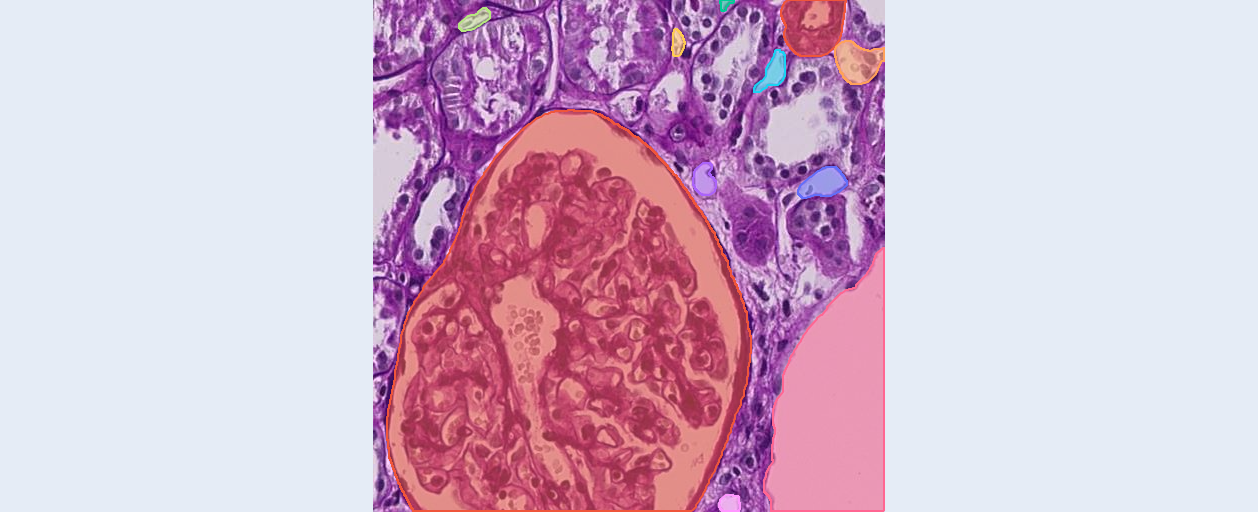

In [14]:
plot_annotated_image(tiles_dicts[1000])

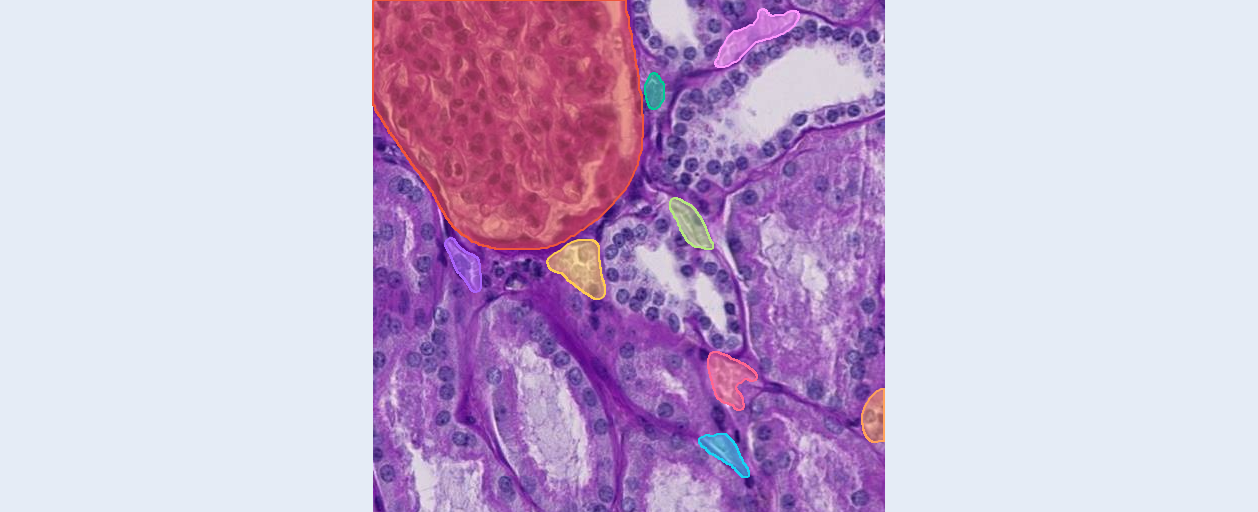

In [15]:
plot_annotated_image(tiles_dicts[0])

In [16]:
len(tiles_dicts)

1633

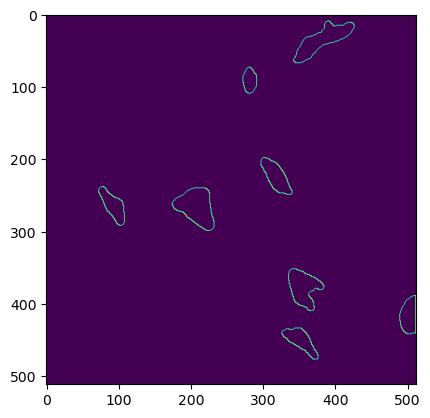

In [17]:
mask = np.zeros((512, 512), dtype=np.float32)
for annot in tiles_dicts[0]['annotations']:
    cords = annot['coordinates']
    if annot['type'] == "blood_vessel":
        for cd in cords:
            rr, cc = np.array([i[1] for i in cd]), np.asarray([i[0] for i in cd])
            mask[rr, cc] = 1
            
plt.imshow(mask)
plt.show()

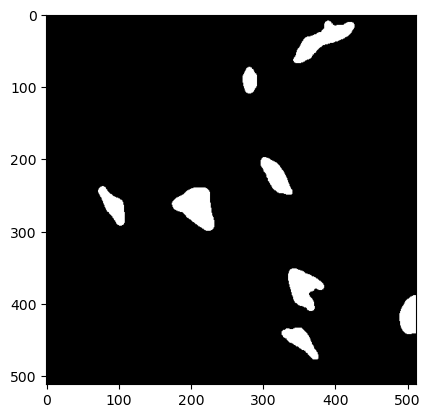

In [18]:
contours,_ = cv2.findContours((mask*255).astype(np.uint8), 1, 2)
zero_img = np.zeros([mask.shape[0], mask.shape[1], 3], dtype="uint8")

for p in contours:
    cv2.fillPoly(zero_img, [p], (255, 255, 255))
    
plt.imshow(zero_img)
plt.show()

(512, 512, 3)
16


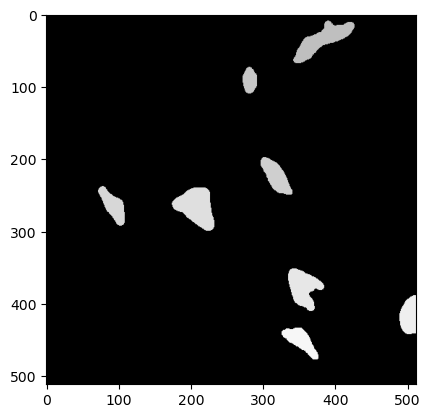

In [19]:
from copy import deepcopy
contours, hierarchy = cv2.findContours(mask.astype("uint8"), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
img_with_area = zero_img
print(img_with_area.shape)

print(len(contours))
        
for i in range(len(contours)):
    if cv2.contourArea(contours[i]) > (mask.shape[0] * mask.shape[1]) * 0.0001:
        cv2.fillPoly(img_with_area, [contours[i][:,0,:]], (255-4*(i+1),255-4*(i+1),255-4*(i+1)), lineType=cv2.LINE_8, shift=0)
        
plt.imshow(img_with_area)
plt.show()

In [20]:
def make_seg_mask(tiles_dict):
    mask = np.zeros((512, 512), dtype=np.float32)
    for annot in tiles_dict['annotations']:
        cords = annot['coordinates']
        if annot['type'] == "blood_vessel":
            for cd in cords:
                rr, cc = np.array([i[1] for i in cd]), np.asarray([i[0] for i in cd])
                mask[rr, cc] = 1
                
    contours,_ = cv2.findContours((mask*255).astype(np.uint8), 1, 2)
    zero_img = np.zeros([mask.shape[0], mask.shape[1], 3], dtype="uint8")

    for p in contours:
        cv2.fillPoly(zero_img, [p], (255, 255, 255))

    contours, hierarchy = cv2.findContours(mask.astype("uint8"), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    img_with_area = zero_img

    for i in range(len(contours)):
        cv2.fillPoly(img_with_area, [contours[i][:,0,:]], (255-4*(i+1),255-4*(i+1),255-4*(i+1)), lineType=cv2.LINE_8, shift=0)
            
    return img_with_area 

In [21]:
import os
import cv2
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# Directories
base_dir = r'C:\Users\MGS4T\Downloads\HuBMAP_New\images\train'
train_images_dir = r'C:\Users\MGS4T\Downloads\HuBMAP_New\images\train_images'
train_masks_dir = r'C:\Users\MGS4T\Downloads\HuBMAP_New\images\train_masks'
val_images_dir = r'C:\Users\MGS4T\Downloads\HuBMAP_New\images\val_images'
val_masks_dir = r'C:\Users\MGS4T\Downloads\HuBMAP_New\images\val_masks'

# Create directories if they don't exist
for directory in [train_images_dir, train_masks_dir, val_images_dir, val_masks_dir]:
    os.makedirs(directory, exist_ok=True)

image_paths = []
mask_paths = []

# Using tqdm to show progress while processing images
for tldc in tqdm(tiles_dicts, desc="Processing Images"):
    array = tif.imread(CFG.img_path_template.format(tldc["id"]))
    img_example = Image.fromarray(array)
    img = np.array(img_example)
    mask = make_seg_mask(tldc)
    
    if np.sum(mask) > 0:
        img_path = os.path.join(base_dir, f'{tldc["id"]}.png')
        mask_path = os.path.join(base_dir, f'{tldc["id"]}_mask.png')
        
        cv2.imwrite(img_path, img)
        cv2.imwrite(mask_path, mask)
        
        image_paths.append(img_path)
        mask_paths.append(mask_path)

# Split the data into train and validation sets
train_imgs, val_imgs, train_masks, val_masks = train_test_split(image_paths, mask_paths, test_size=0.2, random_state=42)

# Move training images and masks to appropriate directories
for img_path in tqdm(train_imgs, desc="Moving Training Images"):
    dest_path = os.path.join(train_images_dir, os.path.basename(img_path))
    if not os.path.exists(dest_path):
        os.rename(img_path, dest_path)

for mask_path in tqdm(train_masks, desc="Moving Training Masks"):
    dest_path = os.path.join(train_masks_dir, os.path.basename(mask_path))
    if not os.path.exists(dest_path):
        os.rename(mask_path, dest_path)

# Move validation images and masks to appropriate directories
for img_path in tqdm(val_imgs, desc="Moving Validation Images"):
    dest_path = os.path.join(val_images_dir, os.path.basename(img_path))
    if not os.path.exists(dest_path):
        os.rename(img_path, dest_path)

for mask_path in tqdm(val_masks, desc="Moving Validation Masks"):
    dest_path = os.path.join(val_masks_dir, os.path.basename(mask_path))
    if not os.path.exists(dest_path):
        os.rename(mask_path, dest_path)


Moving Validation Masks: 100%|██████████| 325/325 [00:00<00:00, 29539.27it/s]


In [22]:
# dataset.py


class hubmapDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = os.listdir(image_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        img_path = os.path.join(self.image_dir, self.images[index])
        mask_path = os.path.join(self.mask_dir, self.images[index].replace(".png", "_mask.png"))
        image = np.array(Image.open(img_path).convert("RGB"))
        mask = np.array(Image.open(mask_path).convert("L"), dtype=np.float32)
        mask[mask == 255.0] = 1.0

        if self.transform is not None:
            augmentations = self.transform(image=image, mask=mask)
            image = augmentations["image"]
            mask = augmentations["mask"]

        return image, mask

In [23]:
# utils.py

def save_checkpoint(state, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    torch.save(state, filename)

def load_checkpoint(checkpoint, model):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])

def get_loaders(
    train_dir,
    train_maskdir,
    val_dir,
    val_maskdir,
    batch_size,
    train_transform,
    val_transform,
    num_workers=4,
    pin_memory=True,
):
    train_ds = hubmapDataset(
        image_dir=train_dir,
        mask_dir=train_maskdir,
        transform=train_transform,
    )

    train_loader = DataLoader(
        train_ds,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=pin_memory,
        shuffle=True,
    )

    val_ds = hubmapDataset(
        image_dir=val_dir,
        mask_dir=val_maskdir,
        transform=val_transform,
    )

    val_loader = DataLoader(
        val_ds,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=pin_memory,
        shuffle=False,
    )

    return train_loader, val_loader

def check_accuracy(loader, model, device="cuda"):
    num_correct = 0
    num_pixels = 0
    dice_score = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device).unsqueeze(1)
            preds = torch.sigmoid(model(x))
            preds = (preds > 0.5).float()
            num_correct += (preds == y).sum()
            num_pixels += torch.numel(preds)
            dice_score += (2 * (preds * y).sum()) / (
                (preds + y).sum() + 1e-8
            )

    print(
        f"Got {num_correct}/{num_pixels} with acc {num_correct/num_pixels*100:.2f}"
    )
    #print(f"Dice score: {dice_score/len(loader)}") Has an error. Don't use. 
    model.train()

def save_predictions_as_imgs(
    loader, model, folder="saved_images/", device="cuda"
):
    model.eval()
    for idx, (x, y) in enumerate(loader):
        x = x.to(device=device)
        with torch.no_grad():
            preds = torch.sigmoid(model(x))
            preds = (preds > 0.5).float()
        torchvision.utils.save_image(
            preds, f"{folder}/pred_{idx}.png"
        )
        torchvision.utils.save_image(y.unsqueeze(1), f"{folder}{idx}.png")

    model.train()

In [24]:
# model.py

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

class UNET(nn.Module):
    def __init__(
            self, in_channels=3, out_channels=1, features=[64, 128, 256, 512],
    ):
        super(UNET, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Down part of UNET
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Up part of UNET
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature*2, feature, kernel_size=2, stride=2,
                )
            )
            self.ups.append(DoubleConv(feature*2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        return self.final_conv(x)

def test():
    x = torch.randn((3, 1, 161, 161))
    model = UNET(in_channels=1, out_channels=1)
    preds = model(x)
    assert preds.shape == x.shape

if __name__ == "__main__":
    test()

C:\Users\MGS4T\anaconda3\envs\pytorch\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning:

The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).



In [40]:
# train.py

# Hyperparameters etc.
LEARNING_RATE = 0.0001
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 16
NUM_EPOCHS = 1
NUM_WORKERS = 0
IMAGE_HEIGHT = 512  # 1280 originally
IMAGE_WIDTH = 512  # 1918 originally
PIN_MEMORY = True
LOAD_MODEL = False
TRAIN_IMG_DIR = r"C:\Users\MGS4T\Downloads\HuBMAP_New\images\train_images"
TRAIN_MASK_DIR = r"C:\Users\MGS4T\Downloads\HuBMAP_New\images\train_masks"
VAL_IMG_DIR = r"C:\Users\MGS4T\Downloads\HuBMAP_New\images\val_images"
VAL_MASK_DIR = r"C:\Users\MGS4T\Downloads\HuBMAP_New\images\val_masks"

def train_fn(loader, model, optimizer, loss_fn, scaler):
    loop = tqdm(loader)

    for batch_idx, (data, targets) in enumerate(loop):
        data = data.to(device=DEVICE)
        targets = targets.float().unsqueeze(1).to(device=DEVICE)

        # forward
        with torch.cuda.amp.autocast():
            predictions = model(data)
            loss = loss_fn(predictions, targets)

        # backward
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # update tqdm loop
        loop.set_postfix(loss=loss.item())


def main():
    train_transform = A.Compose(
        [
            A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
            A.Rotate(limit=35, p=1.0),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.1),
            A.Normalize(
                mean=[0.0, 0.0, 0.0],
                std=[1.0, 1.0, 1.0],
                max_pixel_value=255.0,
            ),
            ToTensorV2(),
        ],
    )

    val_transforms = A.Compose(
        [
            A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
            A.Normalize(
                mean=[0.0, 0.0, 0.0],
                std=[1.0, 1.0, 1.0],
                max_pixel_value=255.0,
            ),
            ToTensorV2(),
        ],
    )

    model = UNET(in_channels=3, out_channels=1).to(DEVICE)
    loss_fn = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

    train_loader, val_loader = get_loaders(
        TRAIN_IMG_DIR,
        TRAIN_MASK_DIR,
        VAL_IMG_DIR,
        VAL_MASK_DIR,
        BATCH_SIZE,
        train_transform,
        val_transforms,
        NUM_WORKERS,
        PIN_MEMORY,
    )

    if LOAD_MODEL:
        load_checkpoint(torch.load("my_checkpoint.pth.tar"), model)


    check_accuracy(val_loader, model, device=DEVICE)
    scaler = torch.cuda.amp.GradScaler()

    for epoch in range(NUM_EPOCHS):
        train_fn(train_loader, model, optimizer, loss_fn, scaler)

        # save model
        checkpoint = {
            "state_dict": model.state_dict(),
            "optimizer":optimizer.state_dict(),
        }
        save_checkpoint(checkpoint)

        # check accuracy
        check_accuracy(val_loader, model, device=DEVICE)

        # print some examples to a folder
        save_predictions_as_imgs(
            val_loader, model, folder="saved_images/", device=DEVICE
        )


if __name__ == "__main__":
    main()

Got 81359435/85196800 with acc 95.50
Dice score: 0.0


100%|██████████| 82/82 [00:40<00:00,  2.01it/s, loss=-27.3]


=> Saving checkpoint
Got 62394668/85196800 with acc 73.24
Dice score: 1.3889347314834595


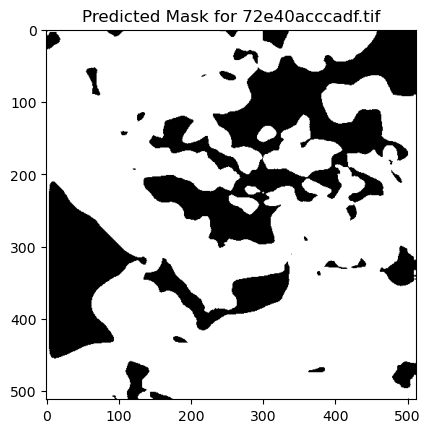

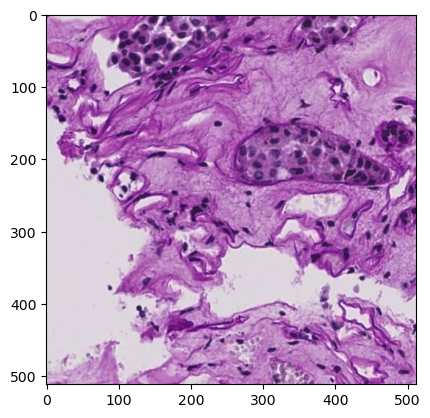

              height  width                                  prediction_string
id                                                                            
72e40acccadf     512    512  0 0.7322006225585938 eNpVWOmW6jqvfCXLCWFoupuZT...


In [41]:
# inference.py

IMAGE_HEIGHT = 512 
IMAGE_WIDTH = 512  
ids = []
heights = []
widths = []
all_imgs = []
prediction_strings = []

class InferenceDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path)
        if self.transform:
            image = self.transform(image=np.array(image))["image"]
        return image, os.path.basename(image_path)  # Return image and filename



def encode_binary_mask(predicted_mask: np.ndarray) -> t.Text:
    """Converts a binary mask into OID challenge encoding ascii text."""

    # check input mask --
    if predicted_mask.dtype != np.bool_:
        raise ValueError(
            "encode_binary_mask expects a binary mask, received dtype == %s" %
            predicted_mask.dtype
        )

    predicted_mask = np.squeeze(predicted_mask)
    if len(predicted_mask.shape) != 2:
        raise ValueError(
            "encode_binary_mask expects a 2d mask, received shape == %s" %
            predicted_mask.shape
        )

    # convert input mask to expected COCO API input --
    predicted_mask_to_encode = predicted_mask.reshape(predicted_mask.shape[0], predicted_mask.shape[1], 1)
    predicted_mask_to_encode = predicted_mask_to_encode.astype(np.uint8)
    predicted_mask_to_encode = np.asfortranarray(predicted_mask_to_encode)

    # RLE encode mask --
    predicted_encoded_mask = coco_mask.encode(predicted_mask_to_encode)[0]["counts"]

    # compress and base64 encoding --
    binary_str = zlib.compress(predicted_encoded_mask, zlib.Z_BEST_COMPRESSION)
    base64_str = base64.b64encode(binary_str)
    return base64_str



# Set the paths
MODEL_PATH = r"C:\Users\MGS4T\Downloads\HuBMAP_New\my_checkpoint.pth.tar"
TEST_IMAGE_PATH = r"C:\Users\MGS4T\Downloads\HuBMAP_New\images\test"
OUTPUT_PATH = r"C:\Users\MGS4T\Downloads\HuBMAP_New\images\output"

def predict(model, image_tensor, filename, device):
    with torch.no_grad():
        output = model(image_tensor.unsqueeze(0))
        predicted_mask = torch.sigmoid(output).cpu().squeeze().numpy()
        predicted_mask = (predicted_mask > 0.5).astype(np.bool_)
        predicted_mask = binary_dilation(predicted_mask)

        # Visualize Mask
        plt.imshow(predicted_mask, cmap='gray')
        plt.title(f"Predicted Mask for {filename}")
        plt.show()
        
    # Encode mask for submission
    encoded = encode_binary_mask(predicted_mask)
    
    # You can use mean or max of the mask as a proxy for "score"
    # Since U-Net doesn't provide a distinct score for the mask
    score = predicted_mask.mean()
    
    pred_string = f"0 {score} {encoded.decode('utf-8')}"
        
    c, h, w = image_tensor.shape
    ids.append(os.path.splitext(filename)[0])  # appending the image filename
    heights.append(h)
    widths.append(w)
    prediction_strings.append(pred_string)

transform = A.Compose(
    [A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
    A.Normalize(mean=[0.0, 0.0, 0.0], std=[1.0, 1.0, 1.0], max_pixel_value=255.0),
    ToTensorV2(),])   

if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = UNET(in_channels=3, out_channels=1).to(device)
    checkpoint = torch.load(MODEL_PATH, map_location=device)
    model.load_state_dict(checkpoint["state_dict"])
    model.eval()


    image_paths = [os.path.join(TEST_IMAGE_PATH, f) for f in os.listdir(TEST_IMAGE_PATH) if f.endswith(".tif")]
    dataset = InferenceDataset(image_paths, transform=transform)
    dataloader = DataLoader(dataset, batch_size=8, shuffle=False)  # Adjust batch_size based on memory availability

    for images, filenames in dataloader:
        images = images.to(device)
        outputs = model(images)    
    # Iterate over each output mask in the batch
        for idx, image_tensor in enumerate(images):
            predict(model, image_tensor, filenames[idx], device)


    # Visualize the first test image and its prediction
    array = tif.imread(r"C:\Users\MGS4T\Downloads\HuBMAP_New\images\test\72e40acccadf.tif")
    plt.imshow(array)
    plt.savefig("original_image.png")   # Save the image to a file
    plt.show()

    # Sumbission code
    submission = pd.DataFrame()
    submission['id'] = ids
    submission['height'] = heights
    submission['width'] = widths
    submission['prediction_string'] = prediction_strings
    submission = submission.set_index('id')
    submission.to_csv("submission.csv")
    print(submission.head())
